# Checking for legislative text reuse using Solr and ngrams

In reproducing [this piece on model legislation](https://www.usatoday.com/pages/interactives/asbestos-sharia-law-model-bills-lobbyists-special-interests-influence-state-laws/), we need to somehow compare our model legislation - bills written by lobbyists - with actual legislation that was proposed or passed. To do this, we'll be using a special analysis module inside of our Solr search index, which we'll then link to our original bills that are off in a postgres database.

In this specific case, we're going to be using an n-gram index in Solr to narrow down our search set, then use scikit-learn to actually measure the similarity of our documents.

<p class="reading-options">
  <a class="btn" href="/azcentral-text-reuse-model-legislation/05-checking-for-legislative-text-reuse-using-python-solr-and-ngrams">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/azcentral-text-reuse-model-legislation/notebooks/05-Checking for legislative text reuse using Python, Solr, and ngrams.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/azcentral-text-reuse-model-legislation/notebooks/05-Checking for legislative text reuse using Python, Solr, and ngrams.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **alec-model-policies.csv:** alec model legislation - TK


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/azcentral-text-reuse-model-legislation/data/alec-model-policies.csv -P data

In [112]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import requests
from sqlalchemy import create_engine
from urllib.parse import urlencode
import pandas as pd
import pysolr

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", 3000)

%matplotlib inline

## What are we doing here?

## Read in model bills

We start by reading in a list of model bills scraped from the [American Legislative Exchange Council](https://www.alec.org/), a leading source of model legislation. In this notebook we're going to look for legislation based off of a single one of these bills. 

In [113]:
df = pd.read_csv("data/alec-model-policies.csv")
df.head(2)

,title,url,content
0,Resolution Supporting Congressional Approval of the United States-Mexico-Canada Agreement (USMCA),https://www.alec.org/model-policy/resolution-supporting-congressional-approval-of-the-united-states-mexico-canada-agreement-usmca/,"\n\nDraft\nResolution Supporting Congressional Approval of the United States-Mexico-Canada Agreement (USMCA)\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nWhereas, the imposition of artificial barriers to free and open trade are harmful to American economic interests; and\nWhereas, together, the United States, Canada and Mexico promote a shared belief in freedom, representative democracy and market principles as recognized in the U.S. Constitution; and\nWhereas, a longstanding, close tri-lateral relationship, codified in the North American Free Trade Agreement (NAFTA), has existed between the United States, Canada, and Mexico for more than 25 years and has proven economically, culturally and strategically important for all parties and this relationship will continue with ratification of USMCA; and\nWhereas, trade with Canada and Mexico supports nearly 12 million American jobs, and nearly 5 million of those jobs are supported by increased trade generated by NAFTA and these benefits will continue with ratification of USMCA; and\nWhereas, since NAFTA entered into force in 1994, trade with Canada and Mexico has nearly quadrupled to $1.3 trillion, and the two countries buy more than one-third of U.S. merchandise exports; and\nWhereas, for 43 states in the United States, Canada and Mexico represent their first or second largest export market and all but one U.S. state count Canada or Mexico as a top three trading partner; and\nWhereas, Canada and Mexico are the two largest trading partners for [INSERT STATE] with [INSERT PERCENTAGE AVAILABLE ON USTR WEBSITE] percent of the state’s goods exports going to Canada and another [INSERT APPROPRIATE PERCENTAGE AVAILABLE ON USTR WEBSITE] percent going to Mexico; and\nWhereas, NAFTA has contributed to a 405% increase in U.S. agricultural exports to Canada and Mexico; and\nWhereas, the modernized USMCA may prove even more beneficial to the agricultural sector than NAFTA and will offer a higher degree of certainty and stability to farmers; and\nWhereas, U.S. service exports to Canada and Mexico have tripled, rising from $27.5 billion in 1993 to $91.3 billion in 2017, thanks to new market access and clearer rules afforded by NAFTA which will be continued under USMCA; and\nWhereas, Canada and Mexico are the top two export destinations for U.S. small and medium-sized enterprises, more than 125,000 of which sold their goods and services in Canada and Mexico in 2014; now\nWhereas, trade among our North American trading partners is made up predominantly of intellectual property (IP)-intensive goods and services that employ millions of Americans in high paying jobs and generate billions of dollars in economic output; and\nWhereas, many of the IP-intensive goods, services and exchanges through which trade is facilitated in the NAFTA bloc did not exist when the agreement was drafted and this situation has resulted in uneven and weak IP enforcement; and\nWhereas, stringent enforcement of IP rights has been found to correlate c..."
1,Resolution Supporting the Intellectual Property (IP) Provisions in the United States-Mexico-Canada Agreement (USMCA),https://www.alec.org/model-policy/draft-resolution-supporting-the-intellectual-property-ip-provisions-in-the-united-states-mexico-canada-agreement-usmca/,"\n\nDraft\nResolution Supporting the Intellectual Property (IP) Provisions in the United States-Mexico-Canada Agreement (USMCA)\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nWhereas, the American Legislative Exchange Council (ALEC) policy on free trade acknowledges that, “the imposition of artificial barriers to free and open trade…are deterrents to American economic interests;” and\nWhereas, the United States, Canada and Mexico share a belief in freedom, representative democr

# Pick the model bill we're interested in

In this notebook we're only looking at a **single source** of model legislation. Let's pick one at random:

In [155]:
target = df.loc[100]
target

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

## Search for content like that bill on Solr

We have some pretty intense text analysis to do, the kind you couldn't do across 1.2 million documents. Instead, we're going to use Solr to pare down our results a bit, then perform our text analysis on that subset.

First, we'll see which bills are **kind of similar** on Solr. We'll do this by adding the model legislation, and asking for ["more like this"](https://lucene.apache.org/solr/guide/8_2/morelikethis.html). Once we have a list of similar bills, we'll delete the model legislation from Solr and perform similarity measurements on the model legislation and the similar bills.

In [115]:
# Do you need to start solr? We used -m 5gb when indexing, but we don't need that much memory when we're searching
!solr start

*** [WARN] ***  Your Max Processes Limit is currently 2048. 
 It should be set to 65000 to avoid operational disruption. 
 If you no longer wish to see this warning, set SOLR_ULIMIT_CHECKS to false in your profile or solr.in.sh

Port 8983 is already being used by another process (pid: 8428)
Please choose a different port using the -p option.



Let's **add the model legislation into Solr**.

In [156]:
solr = pysolr.Solr('http://localhost:8983/solr/legislation', always_commit=True)

# Delete previous model legislations if they're still around
solr.delete(q='bill_id:0')

# Add the model legislation
solr.add([{ 'content': target.content, 'bill_id': 0 }])

'<?xml version="1.0" encoding="UTF-8"?>\n<response>\n\n<lst name="responseHeader">\n  <int name="status">0</int>\n  <int name="QTime">171</int>\n</lst>\n</response>\n'

Let's **ask for other bills like the model legislation**.

In [159]:
# We use content_ngrams because we're loooking for 6-gram matches
# Compare to bill_id of 0
# Max of 1000 rows
# We only need the bill_id and the score
params = urlencode({
    'mlt.fl': 'content_ngrams',
    'q': 'bill_id:0',
    'rows': 1000,
    'fl': 'bill_id,score'
})
mlt_url = 'http://localhost:8983/solr/legislation/mlt?' + params

# Make the request, parse the response
response = requests.get(mlt_url)
data = response.json()

In [165]:
# Turn the results into a dataframe so they're easier to work with
morelikethis = pd.DataFrame(data['response']['docs'])
morelikethis

,bill_id,score
0,795253,142.922200
1,692076,142.922200
2,410009,123.342840
3,1019794,114.861220
4,1239266,114.861220
...,...,...
391,756222,0.072544
392,374366,0.039061
393,1235814,0.026544
394,416174,0.025890


Some of those have a **very, very low score** - almost zero! But because they're returned as matched, we know they have **at least one six-word phrase in common with our model legislation**.

> If we wanted to spend more time on this, we could implement a [custom scorer](https://github.com/o19s/lucene-query-example/blob/master/src/main/java/com/o19s/CountSimilarity.java) in Lucene (the thing that powers Solr) that gives us the number of matches. That'd probably be the best route to filter out the bills that have 1 or 2 matches but nothing that's a true cut-and-paste. Unfortunately they [changed custom scoring in Lucene 8](https://issues.apache.org/jira/browse/LUCENE-8099) and I couldn't figure out how to adapt the code linked above.

In [119]:
# Delete the model legislations we just inserted
solr.delete(q='bill_id:0')

'<?xml version="1.0" encoding="UTF-8"?>\n<response>\n\n<lst name="responseHeader">\n  <int name="status">0</int>\n  <int name="QTime">88</int>\n</lst>\n</response>\n'

# Query database

To see what phrases are shared, let's use the `bill_id` field from our results to request the actual bills from the postgres database. Then we can use the bill content to make a more direct comparison.

In [120]:
engine = create_engine('postgresql://localhost:5432/legislation')

query = "select * from bills where bill_id = ANY(ARRAY{})".format(list(morelikethis.bill_id))
bills_df = pd.read_sql_query(query, engine)
bills_df.head(2)

,id,bill_id,code,bill_number,title,description,state,session,filename,status,status_date,url,error,content,processed_at
0,1050681,42802,HB301,HB301,To extend the imposition of the current Advanced Energy Fund revenue rider on retail electric distribution service rates by three years and to clarify how Advanced Energy Fund grant amounts are to be determined.,"To amend sections 4928.58, 4928.61, and 4928.62 of the Revised Code to extend the imposition of the current Advanced Energy Fund revenue rider on retail electric distribution service rates by three years and to clarify how Advanced Energy Fund grant amounts are to be determined.",OH,128th General Assembly (2009-2010),bill_data/OH/2009-2010_128th_General_Assembly/bill/HB301.json,2,2010-12-08,http://archives.legislature.state.oh.us/BillText128/128_HB_301_PH_Y.html,None,"Am. Sub. H. B. No. 301 As Passed by the House\n\nAs Passed by the House\n\n\n\t\t128th General Assembly\n\tRegular Session\n\t2009-2010\n\n\t\tAm. Sub. H. B. No. 301\n\n\n\n\n\n\n\n\nRepresentative Foley \n\n\n\n\nCosponsors: \nRepresentatives Celeste, Skindell, Hagan, Stewart, Letson, Murray, Harris, Pryor, Yuko, Domenick, Ujvagi, Yates, Harwood, Winburn, Williams, S., Evans, Pillich, Phillips, Brown, Chandler, DeBose, Garland, Luckie, Mallory, Walter, Weddington, Williams, B. \n\n\n \n\n\nA BILL\n\n\t\tTo amend sections 4928.58, 4928.61, and 4928.62 of \t1\n\n\t\t\nthe Revised Code to extend the imposition of the \t2\n\n\t\t\ncurrent Advanced Energy Fund revenue rider on \t3\n\n\t\t\nretail electric distribution service rates by \t4\n\n\t\t\nthree years and to clarify how Advanced Energy \t5\n\n\t\t\nFund grant amounts are to be determined. \t6\n\n\t\t\n\n\n\n\n\nBE IT ENACTED BY THE GENERAL ASSEMBLY OF THE STATE OF OHIO:\n\n\n\t Section 1. That sections 4928.58, 4928.61, and 4928.62 of the \t7\n\t\nRevised Code be amended to read as follows:\t8\n\n\n\t Sec. 4928.58. (A) There is hereby created the public \t9\n\t\nbenefits advisory board, which has the purpose of ensuring that \t10\n\t\nenergy services be provided to low-income consumers in this state \t11\n\t\nin an affordable manner consistent with the policy specified in \t12\n\t\nsection 4928.02 of the Revised Code. The advisory board shall \t13\n\t\nconsist of twenty-one members as follows: the director of \t14\n\t\ndevelopment, the chairperson of the public utilities commission, \t15\n\t\nthe consumers' counsel, and the director of the air quality \t16\n\t\ndevelopment authority, each serving ex officio and represented by \t17\n\t\na designee at the official's discretion; two members of the house \t18\n\t\nof representatives appointed by the speaker of the house of \t19\n\t\nrepresentatives, neither of the same political party, and two \t20\n\t\nmembers of the senate appointed by the president of the senate, \t21\n\t\nneither of the same political party; and thirteen members \t22\n\t\nappointed by the governor with the advice and consent of the \t23\n\t\nsenate, consisting of one representative of suppliers of \t24\n\t\ncompetitive retail electric service; one representative of the \t25\n\t\nresidential class of electric utility customers; one \t26\n\t\nrepresentative of the industrial class of electric utility \t27\n\t\ncustomers; one representative of the commercial class of electric \t28\n\t\nutility customers; one representative of agricultural or rural \t29\n\t\ncustomers of an electric utility; two customers receiving \t30\n\t\nassistance under one or more of the low-income customer assistance \t31\n\t\nprograms, to represent customers eligible for any such assistance, \t32\n\t\nincluding senior citizens; one representative of the general \t33\n\t\npublic; one representative of local intake agencies; one \t34\n\t\nrepresentative of a community-based organization ...",2019-11-18 04:39:36.166739+00:00
1,468332,62290,SB275,SB275,Professional engineers.,"An act to amend Sections 6704, 6706.3, 6730, 6737.3, 6738, 6740, 6741, and 6787 of, to add Secti

# Find the number of matches

We'll start by building a `CountVectorizer`, to determine every six-word phrase that exists in our source document. Later, we'll use that to see which of those phrases also exist in the potential matches that came from the database. 

> Note that unlike the Solr search, we're now looking for **exact matches**

In [121]:
vectorizer = CountVectorizer(binary=True, ngram_range=(6,6))
vectorizer.fit([target.content])

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(6, 6), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

What are some phrases in our bill?

In [122]:
vectorizer.get_feature_names()[:10]

['11 2012 approved by the alec',
 '2012 amended by the tax and',
 '2012 approved by the alec board',
 '2012 section findings the legislature finds',
 '2013 approved by the alec board',
 '2013 reapproved by the alec board',
 'act disaster period means period that',
 'act facilitating business rapid response to',
 'act may be cited as the',
 'act of 2012 section findings the']

How many possible six-word combinations grams are there?

In [123]:
len(vectorizer.get_feature_names())

1537

Now let's compute **how many six-gram matches each bill has** when compared to our source model legislation.

In [124]:
%%time

# See which bills match which phrases
matrix = vectorizer.transform(bills_df.content)

# Add up the number of matches
sums = matrix.sum(axis=1)

# Throw it into a dataframe
bill_matches = pd.DataFrame({
    'matches': np.squeeze(np.asarray(sums)),
    'bill_id': bills_df.bill_id,
    'title': bills_df.title,
    'code': bills_df.state + "-" + bills_df.bill_number
})
# Out of all of the 6-word phrases that count have matched, how many matched?
bill_matches['match_percent'] = bill_matches.matches / len(vectorizer.get_feature_names()) * 100
bill_matches.sort_values(by='match_percent', ascending=False, inplace=True)

CPU times: user 13.2 s, sys: 414 ms, total: 13.6 s
Wall time: 14.2 s


In [125]:
bill_matches

,matches,bill_id,title,code,match_percent
118,1036,729144,Facilitating Business Rapid Response to State Declared Disasters Act of 2015; create.,MS-HB1622,67.404034
80,941,580946,"Creating the ""West Virginia Infrastructure Emergency Response Act of 2013""",WV-HB2801,61.223162
67,941,530995,"Creating the ""West Virginia Infrastructure Emergency Response Act of 2013""",WV-HB2801,61.223162
107,927,694848,Facilitating Business Rapid Response to State Declared Disasters Act of 2015; create.,MS-SB2762,60.312297
69,869,537280,Creating WV Infrastructure Emergency Response Act of 2013,WV-SB591,56.538712
...,...,...,...,...,...
147,0,820475,Agriculture; removing reference to certain commission; repealer; effective date.,OK-HB2503,0.000000
155,0,836389,Student tuition scholarships; revenue department,AZ-HB2608,0.000000
170,0,844376,Revises the advanced practice registered nurse law,OH-SB279,0.000000
184,0,863761,General Excise Tax Exemption; Federal Goods and Services;,HI-SR125,0.000000


Now that we've gotten rid of the stemming, **some don't even match at all!**

What does the relationship between **Solr score and number of matches** look like? Let's merge our bill results with our solr results to do a little comparison.

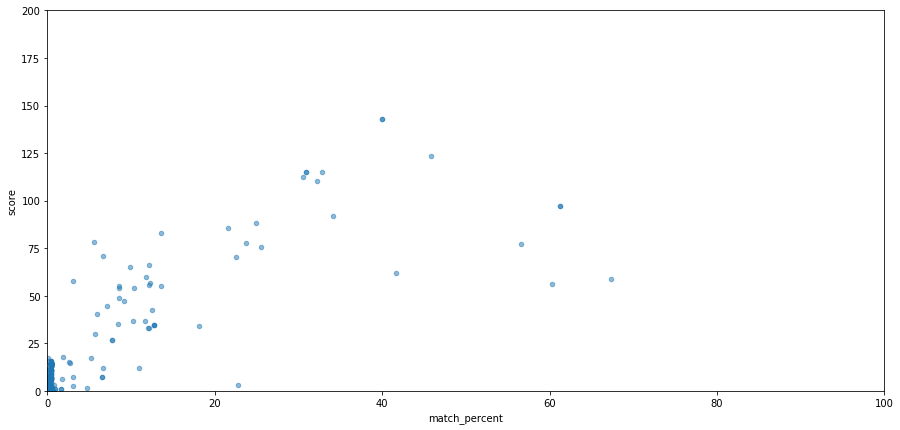

In [129]:
scored = bill_matches.merge(morelikethis, on='bill_id')
scored.plot(x='match_percent', y='score', kind='scatter', alpha=0.5, figsize=(15,7), xlim=(0,100), ylim=(0, 200))

In the future, we can probably **remove bills below a certain score.** I'm not sure what that value is - we'll need to do some additional testing - but it'll save us some time when we're analyzing thousands of pieces of model legislation.

# What are the matching phrases?

While we know which bills have a lot of phrases in common, **what are those phrases?**

In [130]:
# Build a DataGrame of bills and word counts
word_counts = pd.DataFrame(
    matrix.toarray(), 
    columns=vectorizer.get_feature_names(),
    index=bills_df.state + "-" + bills_df.bill_number
)

# Drop any bills or phrases that don't have anything in common
word_counts = word_counts.replace(0, np.nan) \
    .dropna(axis=1, how='all') \
    .dropna(axis=0, how='all')

# Add up the number of shared phrases in each bill
word_counts['TOTAL_ngrams_shared'] = word_counts.sum(axis=1)
word_counts = word_counts.sort_values(by='TOTAL_ngrams_shared', ascending=False)
word_counts = word_counts.T

# Add up the nmber of times each phrase was used in different bills
word_counts['TOTAL_bills_used'] = word_counts.sum(axis=1)
word_counts = word_counts.sort_values(by='TOTAL_bills_used', ascending=False)

# Move 'total times used' to the left-hand column
cols = word_counts.columns.tolist()
cols.insert(0, cols.pop(cols.index('TOTAL_bills_used')))
word_counts = word_counts.loc[:, cols]

word_counts.loc['TOTAL_ngrams_shared', 'TOTAL_bills_used'] = np.nan

In [131]:
word_counts.fillna("").head(20)

,TOTAL_bills_used,MS-HB1622,WV-HB2801,WV-HB2801,WV-HB2801,WV-HB2801,MS-SB2762,WV-SB591,RI-S2604,NC-H335,OK-SB499,OK-SB499,OK-SB499,OK-SB499,SC-S1033,NY-S05323,NY-A07340,NY-A08462,NY-A06649,NY-S05242,NM-SB465,IL-HB5595,NM-SB19,NM-HB396,LA-SB177,MN-SF1091,CA-SB560,IA-HSB617,SD-SB101,NJ-A1342,NJ-A4325,NJ-A857,UT-SB0047,AR-SB925,ME-LD1836,AL-SB309,NJ-S2518,NJ-A3699,GA-HB782,NJ-S978,CO-HB1003,AL-HB365,UT-SB0047S03,ND-2095,LA-HB639,MO-HB1801,MO-HB1190,ND-2199,PA-HB2377,TN-SB0624,...,NH-SB4,UT-SB0021,MO-HB1056,VT-H0314,VT-S0059,OH-SB315,NH-HB153,NH-HB153,NH-HB153,NH-HB153,UT-SB3002,UT-SB0016,UT-SB0023,OH-HB114,UT-HB0403,UT-HB0262,CA-SB920,UT-HB0202,MO-HB2201,AL-HB252,FL-H1415,UT-SB0037,NH-SB106,NH-SB106,NH-SB205,NH-SB205,NH-HB1713,NH-HB1568,NC-H904,MN-SF2062,UT-SB0267,UT-SB0267,NM-SB1,MN-HF1235,MN-HF1259,AZ-HB2530,UT-SB0197,UT-HB0318,RI-H5375,VT-H0441,NH-SB205,NH-SB205,NH-SB106,NH-SB106,MS-SB2896,WA-HB1422,MS-HB967,WA-SB5208,UT-HB0071,OH-HB260
TOTAL_ngrams_shared,,1036,941,941,941,941,927,869,705,641,615,615,615,615,524,504,496,475,475,469,393,383,365,351,347,332,279,208,208,195,195,195,192,188,187,187,186,185,182,179,168,160,158,151,140,132,132,132,129,118,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
the facilitating business rapid response to,129,1,,,,,1,,1,,1,1,1,1,,1,1,1,1,1,,1,,,,1,,1,,,,,1,,,1,,,,,,1,1,,,1,1,,,1,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
facilitating business rapid response to state,126,1,,,,,1,,1,,1,1,1,1,,1,1,1,1,1,,1,,,,,,1,,,,,1,,,,,,,,,,1,,,1,1,,,1,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
rapid response to state declared disasters,126,1,,,,,1,,1,,1,1,1,1,,1,1,1,1,1,,1,,,,,,1,,,,,1,,,,,,,,,,1,,,1,1,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
business rapid response to state declared,126,1,,,,,1,,1,,1,1,1,1,,1,1,1,1,1,,1,,,,,,1,,,,,1,,,,,,,,,,1,,,1,1,,,1,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
response to state declared disasters act,125,1,,,,,1,,1,,1,1,1,1,,1,1,1,1,1,,1,,,,,,1,,,,,1,,,,,,1,,,,1,,,1,1,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
to state declared disasters act of,117,1,,,,,1,,1,,1,1,1,1,,1,1,1,1,1,,1,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
for disaster or emergency related work,69,1,,,,,1,,,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,,,1,1,1,1,1,,,,1,1,,1,,,1,,1,1,1,,,1,...,,1,,,,,,,,,1,1,1,,1,1,,1,,,,1,,,,,,,,,1,,,,,,1,1,,,,,,,,,,,1,
an out of state business that,65,1,1,1,1,1,1,,1,1,1,1,1,1,1,,,,,,1,1,1,1,,1,,1,1,1,1,1,1,1,1,,1,1,,1,,,1,1,,1,1,1,1,,...,,,,,,,,,,,,,,,,,,,1,1,1,,,,1,1,,,1,,,1,,1,,1,,,1,,1,1,,,,1,,1,,
of state business or out of,47,1,1,1,1,1,1,,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,,1,,1,1,1,1,1,1,1,1,,1,1,1,1,,,1,1,,1,1,1,1,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


# Do this all at once

You just want to do this all at once, right? Let's take care of that. We'll also see **what kind of filtering on scores we should do**.

In [172]:
# What are we targeting?
df = pd.read_csv("data/alec-model-policies.csv")
target = df.loc[300]

print("Base legislation is", target.title)

print("Searching Solr")

# Connect to solr, add the model legislation
solr = pysolr.Solr('http://localhost:8983/solr/legislation', always_commit=True)
solr.delete(q='bill_id:0')
solr.add([{ 'content': target.content, 'bill_id': 0 }])

# Use MoreLikeThis to find similar bills
params = urlencode({
    'mlt.fl': 'content_ngrams',
    'q': 'bill_id:0',
    'rows': 1000,
    'fl': 'bill_id,score'
})
mlt_url = 'http://localhost:8983/solr/legislation/mlt?' + params

# Make the request, parse the response, turn it into a dataframe
response = requests.get(mlt_url)
data = response.json()
morelikethis = pd.DataFrame(data['response']['docs'])

print("Found", morelikethis.shape[0], "results")

# Delete the model legislation we just added
solr.delete(q='bill_id:0')

print("Querying Postgres for bill content")
engine = create_engine('postgresql://localhost:5432/legislation')
query = "select * from bills where bill_id = ANY(ARRAY{})".format(list(morelikethis.bill_id))
bills_df = pd.read_sql_query(query, engine)

print("Learning phrases from our model legislation")
vectorizer = CountVectorizer(binary=True, ngram_range=(6,6))
vectorizer.fit([target.content])

print("Counting phrases shared with potential matches")
matrix = vectorizer.transform(bills_df.content)
sums = matrix.sum(axis=1)
bill_matches = pd.DataFrame({
    'matches': np.squeeze(np.asarray(sums)),
    'bill_id': bills_df.bill_id,
    'title': bills_df.title,
    'code': bills_df.state + "-" + bills_df.bill_number
})
bill_matches['match_percent'] = bill_matches.matches / len(vectorizer.get_feature_names()) * 100
bill_matches.sort_values(by='match_percent', ascending=False, inplace=True)

print("Combining with Solr scores")
scored = bill_matches.merge(morelikethis, on='bill_id')

print("Done")

Base legislation is Draft Resolution Urging the Presidential Administration and Congress to Support Stronger Intellectual Property Protections in an Updated North American Free Trade Agreement (NAFTA)
Searching Solr
Found 1000 results
Querying Postgres for bill content
Learning phrases from our model legislation
Counting phrases shared with potential matches
Combining with Solr scores
Done


In [173]:
scored.head()

,matches,bill_id,title,code,match_percent,score
0,110,1272954,The United States-Mexico-Canada Agreement.,CA-SJR12,23.809524,15.995613
1,90,1265997,Memorializes congress to approve the United States-Mexico-Canada Agreement,LA-HR261,19.480519,11.555555
2,50,1255211,A resolution to urge the Congress of the United States to speedily approve the recently negotiated United States-Mexico-Canada Agreement.,MI-HR0081,10.822511,11.470130
3,50,1274053,A resolution to urge the Congress of the United States to speedily approve the recently negotiated United States-Mexico-Canada Agreement.,MI-SR0073,10.822511,11.246828
4,24,1237211,Trade agreement; ratification; urging Congress,AZ-SM1002,5.194805,11.772088


### Add in the content

Maybe you'd like to see the content of the bills now? No big deal, we can do that.

In [178]:
with_content = scored.merge(bills_df.drop(columns=['title', 'code']), on='bill_id')
with_content

,matches,bill_id,title,code,match_percent,score,id,bill_number,description,state,session,filename,status,status_date,url,error,content,processed_at
0,110,1272954,The United States-Mexico-Canada Agreement.,CA-SJR12,23.809524,15.995613,475735,SJR12,Relative to the United States-Mexico-Canada Agreement.,CA,2019-2020 Regular Session,bill_data/CA/2019-2020_Regular_Session/bill/SJR12.json,2,2019-08-30,http://leginfo.legislature.ca.gov/faces/billTextClient.xhtml?bill_id=201920200SJR12,None,"Bill Text - SJR-12 The United States-Mexico-Canada Agreement.\n\n\n\n\n\n\n \n \n\n \n \tskip to content\n\thome\n\taccessibility\n\tFAQ\n\tfeedback\n\tsitemap\n\tlogin\n \n\tx\n\n\n \n\n\n\n\n \n \n \n\n \n \n \n \n \n \n \n\n \n \n\n \n \n Quick Search:\n \n\n Bill Number\nBill Keyword\n\n\n \n \n\n \n\n\n\n \n\n\n\n\n \tHome\n \n\tBill Information\n\n\n \n\tCalifornia Law\n \n\tPublications\n\n\n \n\tOther Resources\n \n\tMy Subscriptions\n \n\tMy Favorites\n \n\n\n \n\n \n\n\n\n \n \n \n \n \n \n\n\n \n \tBill Information\n >>\n \n\tBill Search\n >>\n \n\tText\n\n\n \n\n Bill Text\n\n \n\n\n\n\n \n PDF2\n PDF\n \n \n\n\n |Add To My Favorites |Track Bill | Version:08/14/19 - Introduced\n\n\n\n\n \n \n \n\n\n \n \n SJR-12 The United States-Mexico-Canada Agreement.(2019-2020)\n \n\n \n\n \n\n \n\n\n Text\n \n >>\n\n \n\n\n\n Votes\n \n >>\n\n \n\n\n\n History\n >>\n\n \n\n\n\n Bill Analysis\n >>\n\n \n\n\n\n Today's Law As Amended\n >>\n\n \n\n \n\n\n\n Compare Versions\n >>\n\n\n \n\n\n\n Status\n >>\n\n \n\n Comments To Author\n \n >>\n\n \n Track Bill\n >>\n\n \n Add To My Favorites\n >>\n\n\n \n\n \n\n \n\n\n\n\n\n \n SHARE THIS:\n \n\n \n \n \n \n\n\n\nBill Start\n\n\t\n\n\n\n\n CALIFORNIA LEGISLATURE—\n 2019–2020 REGULAR SESSION\n\n\n Senate Joint Resolution\n \nNo. 12\n\n\n\tIntroduced by Senator Grove\n\n\t\nAugust 14, 2019\n\n\n\n\n Relative to the United States-Mexico-Canada Agreement. \n\n\nLEGISLATIVE COUNSEL'S DIGEST\n\n\nSJR 12, as introduced, Grove.\n The United States-Mexico-Canada Agreement.\nThis measure would recognize the benefits of improving existing trade relations between the United States, Mexico, and Canada, and would urge Congress to approve the United States-Mexico-Canada Agreement.\n\nDigest Key\n\n Fiscal Committee:\n NO \n\nBill Text\nWHEREAS, The imposition of artificial barriers to free and open trade are harmful to American economic interests; and \nWHEREAS, Together, the United States, Canada, and Mexico promote a shared beli...",2019-11-18 09:14:44.783689+00:00
1,90,1265997,Memorializes congress to approve the United States-Mexico-Canada Agreement,LA-HR261,19.480519,11.555555,1159473,HR261,Memorializes congress to approve the United States-Mexico-Canada Agreement,LA,2019 Regular Session,bill_data/LA/2019-2019_Regular_Session/bill/HR261.json,4,2019-06-02,http://www.legis.la.gov/Legis/ViewDocument.aspx?d=1140431,None,"ENROLLED\n\n2019 Regular Session\n\nHOUSE RESOLUTION NO. 261\n\nBY REPRESENTATIVE GAROFALO\n\nA RESOLUTION\n\nTo memorialize the United States Congress to take such actions as are necessary to approve\n\nthe United States-Mexico-Canada Agreement in order to ensure continuity in trade\n\namong the three North American economic partners.\n\nWHEREAS, the imposition of artificial barriers to free and open trade are harmful\n\nto American economic interests; and\n\nWHEREAS, together, the United States, Canada, and Mexico promote a shared belief\n\nin freedom, representative democracy, and market principles as recognized in the\n\nConstitution of United States; and\n\nWHEREAS, a longstanding, close, trilateral relationship, codified in the North\n\nAmerican Free Trade Agreement (NAFTA), has existed between the United States, Canada,\n\nand Mexico for more than twenty years and has proven economically, culturally, and\n\nstrategically important for all parties; and\n\nWHEREAS, the United States-Mexico-Canada Agreement is a renegotiation of\n\nNAFTA and will extend the benefits enjoyed as a result of NAFTA;

## Which phrases repeat where?

A cut-and-paste from the previous section

In [179]:
# Build a DataGrame of bills and word counts
word_counts = pd.DataFrame(
    matrix.toarray(), 
    columns=vectorizer.get_feature_names(),
    index=bills_df.state + "-" + bills_df.bill_number
)

# Drop any bills or phrases that don't have anything in common
word_counts = word_counts.replace(0, np.nan) \
    .dropna(axis=1, how='all') \
    .dropna(axis=0, how='all')

# Add up the number of shared phrases in each bill
word_counts['TOTAL_ngrams_shared'] = word_counts.sum(axis=1)
word_counts = word_counts.sort_values(by='TOTAL_ngrams_shared', ascending=False)
word_counts = word_counts.T

# Add up the nmber of times each phrase was used in different bills
word_counts['TOTAL_bills_used'] = word_counts.sum(axis=1)
word_counts = word_counts.sort_values(by='TOTAL_bills_used', ascending=False)

# Move 'total times used' to the left-hand column
cols = word_counts.columns.tolist()
cols.insert(0, cols.pop(cols.index('TOTAL_bills_used')))
word_counts = word_counts.loc[:, cols]

word_counts.loc['TOTAL_ngrams_shared', 'TOTAL_bills_used'] = np.nan
word_counts.fillna("", inplace=True)

In [180]:
word_counts.head(20)

,TOTAL_bills_used,CA-SJR12,LA-HR261,MI-SR0073,MI-SR0073,MI-HR0081,AZ-SM1002,CA-AR68,CA-AR71,CA-AJR44,OH-HR300,ME-HP1392,OR-SJM9,OR-SJM9,CA-AJR39,CA-SJR28,CA-SJR28,ME-SP0651,PA-HR38,OH-HCR32,CA-SJR11,CA-SJR11,MI-HR0032,PA-HR264,PA-HR222,ME-SP0382,PA-SR340,PA-SR119,CA-SJR1,CA-SJR1,ME-HP0963,VT-SR0013,OR-HJM1,OR-HJM3,OR-HJM3,OR-SJM7,OR-SJM7,OR-SJM7,OH-SCR9,TX-SCR38,TX-HCR72,MN-HF826,OR-SJM5,OR-SJM5,OR-SJM5,MI-SCR0018,OR-HJM9,OR-HJM9,OR-HJM9,OR-HJM9,...,NJ-A5337,NJ-A1229,NJ-S2553,NJ-A3839,NJ-A3706,NJ-A3935,NJ-S2599,NJ-A4140,NJ-S2670,NJ-A3574,NJ-A2796,NJ-S1861,CA-AB2410,NJ-S1539,NJ-S1525,NJ-S1519,NJ-A2381,NJ-A2121,NJ-A2118,NJ-S1122,NJ-S939,NJ-A448,NJ-A623,NJ-A624,NJ-S2375,NJ-S1978,NJ-S3006,NJ-S1977,NJ-A1268,NJ-A1001,NJ-S308,NJ-A691,NJ-A1252,NJ-A831,NJ-A692,NJ-A1528,NJ-A4155,NJ-A4027,CA-AB1919,NJ-S1110,NJ-A2159,NJ-A2556,NJ-S1305,NJ-A2918,NJ-S1372,NJ-A2643,NJ-S1657,CA-SB1208,NJ-S1956,IL-HR0016
TOTAL_ngrams_shared,,110,90,50,5,50,24,13,13,13,13,12,12,6,12,12,7,11,11,11,11,6,11,11,11,11,11,10,10,7,10,10,9,9,8,9,9,6,9,9,9,9,9,9,7,9,9,8,7,5,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
the president of the united states,962,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
and be it further resolved that,753,1,,1,1,1,,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,,1,1,,1,1,,1,1,1,1,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
to the president of the united,624,1,1,1,1,1,1,,,1,1,,1,1,1,,1,,1,1,,1,,1,1,,1,,,,,,1,1,1,1,1,1,,1,1,1,1,1,1,1,1,1,1,1,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
president of the united states to,543,1,,,,,,1,1,1,1,1,1,1,,1,1,,,1,,1,1,,,,,,1,1,,,1,1,1,1,1,1,,1,1,,1,1,1,1,1,1,1,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
the congress of the united states,497,1,1,1,,1,1,1,1,1,1,1,1,1,1,1,1,1,1,,1,1,,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,,,1,1,1,1,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
of the united states to the,429,1,,,,,,1,1,,,1,1,1,,1,,,,,,,,,,,,,1,1,,,1,1,1,1,1,1,,1,1,,1,1,1,,1,1,1,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
president of the united states and,315,,,,1,,,1,1,1,1,1,1,,1,1,1,1,1,1,1,,,1,1,1,1,1,1,,1,1,1,1,1,1,1,,1,,1,,1,1,1,1,1,1,,1,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1
now therefore be it resolved that,285,,,,,,,,,,1,,,,,,,1,,1,,,,,,1,,,,,,,,,,,,,,1,1,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
of the united states and the,261,,,,1,,,1,1,1,1,1,1,,1,1,1,1,1,1,1,1,,1,1,1,1,1,1,,1,1,1,1,1,1,1,,1,,1,1,1,1,1,1,1,1,,1,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [72]:
len(vectorizer.get_feature_names())

748